In [ ]:
!python --version

Python 3.8.16


In [ ]:
!pip install pyfstat

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 138.4/138.4 KB 5.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 48.4/48.4 MB 10.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.8/79.8 KB 8.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.3/45.3 KB 5.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 51.0/51.0 KB 6.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 66.0 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 52.8/52.8 KB 6.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 132.0/132.0 KB 15.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [ ]:
import cv2, math, h5py
import pyfstat
import numpy as np
from scipy import stats
from pathlib import Path
from collections import defaultdict
from matplotlib import pyplot as plt
%matplotlib inline

from tqdm.auto import tqdm
from joblib import Parallel, delayed

path = Path('/content/drive/MyDrive/KAGGLE/G2NetDCGW/input')
pyfstat.__version__

'1.19.1'

In [ ]:
t_start = 1238166018 // 1800 * 1800
# background noise
writer_kwargs = {
        'sqrtSX': 1e-23, # Single-sided Amplitude Spectral Density of the noise
        'Tsft': 1800, # Fourier transform time duration
        "SFTWindowType": "tukey",  # Window function to compute short Fourier transforms
        "SFTWindowBeta": 0.01,  # Parameter associated to the window function
        "detectors": "H1,L1",
        'tstart': t_start,
        'duration':(1248512757 - t_start) // 1800 * 1800
}

signal_params = {
    # polarization angle
    'psi': np.random.uniform(-math.pi / 4, math.pi / 4),
    # phase
    'phi': np.random.uniform(0, math.pi * 2),
    # Cosine of the angle between the source and us. Range: [-1, 1]
    'cosi': np.random.uniform(-1, 1),
    # Central frequency of the band to be generated [Hz]
    'F0': np.random.uniform(50, 500),
    'F1': -10**stats.uniform(-12, 4).rvs(),
    'F2': 0.0,
    'Band': 0.2, # Frequency band-width around F0 [Hz]
    'Alpha': np.random.uniform(0, math.pi * 2), # Right ascension of the source's position on the sky
    'Delta': np.random.uniform(-math.pi / 2, math.pi / 2), # Declination of the source's position on the sky,
    'tp': t_start, #+ 86400 * random.randint(0, 30), # signal offset
    # 'h0': writer_kwargs["sqrtSX"] * np.random.uniform(0.10, 0.02),
    'h0': writer_kwargs["sqrtSX"] * 100,
    # 'asini': random.randint(10, 500), # amplitude of signal
    # 'period': random.randint(90, 730) * 86400,
}
writer = pyfstat.BinaryModulatedWriter(**writer_kwargs, **signal_params)
writer.make_data()
frequency, timestamps, amplitudes = pyfstat.utils.get_sft_as_arrays(
    writer.sftfilepath
)

In [ ]:
timestamps

{'H1': array([1238166000, 1238167800, 1238169600, ..., 1248507000, 1248508800,
        1248510600]),
 'L1': array([1238166000, 1238167800, 1238169600, ..., 1248507000, 1248508800,
        1248510600])}

In [ ]:
a = np.abs(amplitudes['H1'][-360:, :])
a.shape

(360, 5748)

In [ ]:
a = a[:, :256 * 22].reshape(360, 512, 11).mean(axis=2)
a = (a - a.min())
a = a * 255 / (a.max())

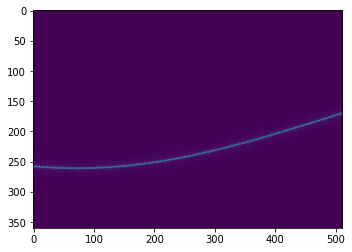

In [ ]:
plt.imshow(a)

In [ ]:
writer_kwargs = {
    "label": "single_detector_gaussian_noise",
    "outdir": "PyFstat_example_data",
    "tstart": 1238166018,  # Starting time of the observation [GPS time]
    ### len
    "duration": (1248512757 - t_start) // 1800 * 1800,  # Duration [seconds]
    "detectors": "H1,L1",  # Detector to simulate, in this case LIGO Hanford
    #######
    "F0": 100.0,  # Central frequency of the band to be generated [Hz]
    "Band": 1.0,  # Frequency band-width around F0 [Hz]
    #######
    "sqrtSX": 1e-23,  # Single-sided Amplitude Spectral Density of the noise
    "Tsft": 1800,  # Fourier transform time duration
    "SFTWindowType": "tukey",  # Window function to compute short Fourier transforms
    "SFTWindowBeta": 0.01,  # Parameter associated to the window function
}
writer = pyfstat.Writer(**writer_kwargs)
writer.make_data()
frequency, timestamps, amplitudes = pyfstat.utils.get_sft_as_arrays(
    writer.sftfilepath
)

In [ ]:
a = np.abs(amplitudes['H1'][-360:, :])
a.shape

(360, 5748)

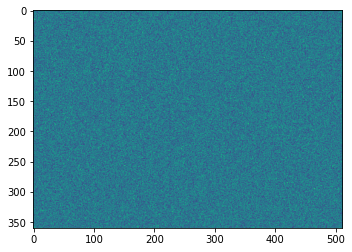

In [ ]:
a = a[:, :256 * 22].reshape(360, 512, 11).mean(axis=2)
a = (a - a.min())
a = a * 255 / (a.max())
plt.imshow(a)

Имитация реального шума

> Копирование временной динамики шума от источника в сгенерированную спектрограмму. Эта логика учитывает пробелы. Сегменты равномерно распределяются во времени, независимо от потенциальных промежутков.

> Это помогает нам генерировать менее «зубчатые» сигналы как на тестовых, так и на сгенерированных спектрограммах.

In [ ]:
def make_data(name_file: str) -> dict:
    r"""  
    name_file: str name.hdf5
    return: {id: str, freq: [], L1: [[], []], H1:[[], []]}    
    """
    data = defaultdict(dict)
    with h5py.File(path / name_file, "r") as f:
        idk = list(f.keys())[0]
        data[idk]['freq'] = np.array(f[idk]['frequency_Hz'])
        for k in ['L1', 'H1']:
            data[idk][k] = [np.array(f[idk][k]['SFTs']), np.array(f[idk][k]['timestamps_GPS'])]
    return data


def bin_noise(data: np.array, ts: np.array, bin: int = 256) -> list:
    r""" Split data by by bin, mean all data between split index, or fill mean data
    This idea get smooths results.
        data: amplitudes
        ts: time timestamps
        bin: int
    return: tuple    
    """
    bin_size = (ts.max() - ts.min()) // bin
    idx = np.searchsorted(ts, [ts[0] + bin_size * i for i in range(bin)])
    global_noise = np.mean(np.abs(data))
    return np.array(
        [np.mean(np.abs(i)) if i.shape[1] > 0 else global_noise for i in np.array_split(data, idx[1:], axis=1)]
    )

smooth_noise = bin_noise(amplitudes['H1'], timestamps['H1'])
plt.plot(smooth_noise)

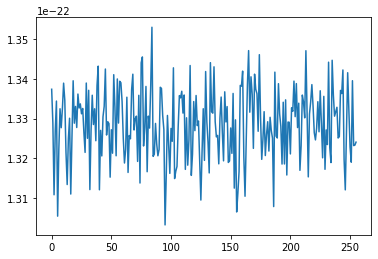

In [ ]:
data = make_data('train_001121a05.hdf5')
smooth_noise = bin_noise(data['001121a05']['H1'][0], data['001121a05']['H1'][1], 256)
plt.plot(smooth_noise)

looks like equalss maybe ...

In [ ]:
t_start = 1238166018 // 1800 * 1800
writer_kwargs = {
        'sqrtSX': 1e-23, 
        'Tsft': 1800, 
        "SFTWindowType": "tukey", 
        "SFTWindowBeta": 0.01, 
        "detectors": "H1,L1",
        'tstart': t_start,
        'duration':(1248512757 - t_start) // 1800 * 1800
}
signal_params = {  
    'psi': np.random.uniform(-math.pi / 4, math.pi / 4),  
    'phi': np.random.uniform(0, math.pi * 2),
    'cosi': np.random.uniform(-1, 1),  
    'F0': np.random.uniform(50, 500),
    'F1': -10**stats.uniform(-12, 4).rvs(),
    'F2': 0.0,
    'Band': 0.2,
    'Alpha': np.random.uniform(0, math.pi * 2),
    'Delta': np.random.uniform(-math.pi / 2, math.pi / 2),
    'tp': t_start,    
    'h0': writer_kwargs["sqrtSX"] * 100,
}

In [ ]:
def make_image(data: np.array) -> np.array:
    r"""
    Get data shape [361: 5000], convert to imge view
        361 -> 360
        5000 -> div for equal part on all image and mean to 1 dim
    norm image * 255
    return: []    
    """
    tmp = np.abs(data[-360:, :])
    tmp = tmp[:, :256 * 22].reshape(360, 512, 11).mean(axis=2)
    tmp = (tmp - tmp.min())
    tmp = tmp * 255 / (tmp.max())
    return tmp


def make_clear_signal(idx: int) -> None:
    r""" Generate clear signal """
    np.random.seed(idx)
    writer = pyfstat.BinaryModulatedWriter(**writer_kwargs, **signal_params)
    writer.make_data()
    frequency, timestamps, amplitudes = pyfstat.utils.get_sft_as_arrays(
        writer.sftfilepath
    )
    p = Path(f'temp/{idx:05d}')
    p.mkdir(parents=True, exist_ok=True)    
    for position in ['H1', 'L1']:
        img = make_image(amplitudes[position])
        # print(p / f'{position}.png')
        cv2.imwrite(str(p / f'{position}.png'), img)

In [ ]:
make_clear_signal(200)

temp/00200/H1.png
temp/00200/L1.png


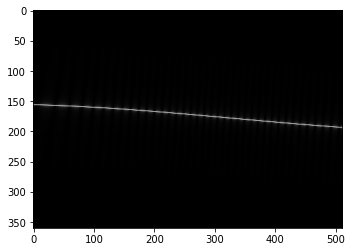

In [ ]:
plt.imshow(cv2.imread('/content/temp/00200/H1.png'))

In [ ]:
_ = Parallel(n_jobs=-1)(
    delayed(make_clear_signal)(idx) for idx in tqdm(range(10)))

  0%|          | 0/10 [00:00<?, ?it/s]

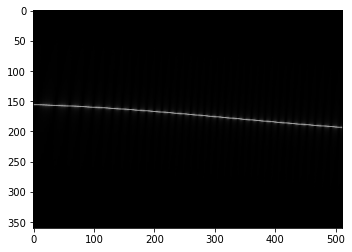

In [ ]:
plt.imshow(cv2.imread('/content/temp/00009/L1.png'))

In [ ]:
import copy

In [ ]:
C_SQRSX = 26.5
data = make_data('train_001121a05.hdf5')
noise = bin_noise(data['001121a05']['H1'][0], data['001121a05']['H1'][1], 256)
writer_kwargs = {
    "detectors": 'H1', 
    "F0": np.mean(data['001121a05']['freq']),  # Central frequency of the band to be generated [Hz]
    'Band': 1/5.01, 
    "Tsft": 1800,
    "SFTWindowType": "tukey",
    "SFTWindowBeta": 0.01,
    "duration": 256
}
""" make noise by segments and join """
all_args = []
for i in range(256):
    args = copy.deepcopy(writer_kwargs)
    args["label"] = f"segment_{i}"
    args["sqrtSX"] = noise[i] / C_SQRSX
    args["tstart"] = data['001121a05']['H1'][1][0] + i * 256
    all_args.append(args)

In [ ]:
all_args[-2:]

[{'detectors': 'H1',
  'F0': 53.6075,
  'Band': 0.1996007984031936,
  'Tsft': 1800,
  'SFTWindowType': 'tukey',
  'SFTWindowBeta': 0.01,
  'duration': 256,
  'label': 'segment_254',
  'sqrtSX': 4.993632656208714e-24,
  'tstart': 1238235045},
 {'detectors': 'H1',
  'F0': 53.6075,
  'Band': 0.1996007984031936,
  'Tsft': 1800,
  'SFTWindowType': 'tukey',
  'SFTWindowBeta': 0.01,
  'duration': 256,
  'label': 'segment_255',
  'sqrtSX': 4.9965128022578444e-24,
  'tstart': 1238235301}]

In [ ]:
tmp = []
"""
writer.sftfilepath
>> ./H-1_H1_1800SFT_segment_255-1238235301-1800.sft

"""
for i in range(256):
    writer = pyfstat.Writer(**all_args[i])
    writer.make_data()
    tmp.append(writer.sftfilepath)

In [ ]:
_, t, fd =  pyfstat.utils.get_sft_as_arrays(';'.join(tmp))

In [ ]:
fd['H1'].shape

(361, 256)

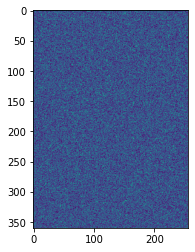

In [ ]:
a = np.abs(fd['H1'][-360:, :])
# a = a[:, :256]=2)
a = (a - a.min())
a = a * 255 / (a.max())
plt.imshow(a)


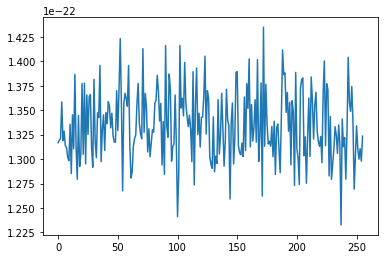

In [ ]:
smooth_noise = bin_noise(fd['H1'], t['H1'], 256)
plt.plot(smooth_noise)

In [ ]:
a = data['001121a05']['H1'][0]
a.shape

(360, 4612)

horizontal lines

In [ ]:
b = np.std(a.astype(np.complex128)[:, :4096].reshape(360, 32, -1), axis=-1)
np.mean(b), np.std(b)

(1.4921371495108264e-22, 6.649566524057325e-24)

In [ ]:
b = np.std(a[:, :4096].reshape(360, 32, -1), axis=-1)
np.mean(b), np.std(b)

(1.4904549e-22, 0.0)

In [ ]:
sft_stds = np.std(a.astype(np.complex128)[:, :4096].reshape(360, 32, -1), axis=-1)
mean_std = np.mean(sft_stds)
std_std = np.std(sft_stds)
line_idx = np.where(sft_stds > mean_std + std_std * 5)
line_amp = sft_stds[line_idx] / mean_std
line_idx

(array([], dtype=int64), array([], dtype=int64))

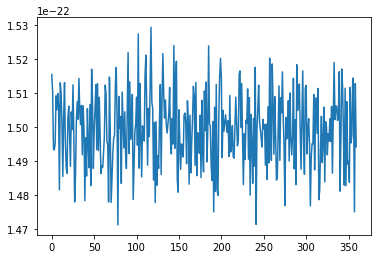

In [ ]:
plt.plot(np.std(a.astype(np.complex128), axis=1))

In [ ]:
https://www.kaggle.com/code/analokamus/fast-online-noise-generation/notebook?scriptVersionId=115544433